In [24]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Section 1
preparation of the dataset

In [25]:
#building set for training and testing since dataset is not nicely formatted...

#this dataset was found on kaggle source: https://www.kaggle.com/datasets/andriitrelin/cells-raman-spectra

#getting names of every folder 
items=[]
for name in os.listdir('.\\archive'):
    items.append(name)
items.remove('README.txt')

#read csvs and append target variable:tumor associated A, A-S, G, G-S, ZAM, ZAM-S (Y or 1)
#nontumor: DMEM, DMEM-S, G, G-S, HF, HF-S, MEL, MEL-S (N or 0)
df=pd.DataFrame()
for name in items:
    temp_dir=pd.read_csv('.\\archive\\'+str(name)+'\\COOH.csv')
    if name in ['A', 'A-S', 'G', 'G-S', 'ZAM', 'ZAM-S']:
        temp_dir['target_variable']=1
    if name in ['DMEM', 'DMEM-S', 'G', 'G-S', 'HF', 'HF-S', 'MEL', 'MEL-S']:
        temp_dir['target_variable']=0
    df=pd.concat([df,temp_dir],ignore_index=False)


In [26]:
#check final dataset
check=0
for i in [0,1]:
    n_entries=len(df[df['target_variable']==i])
    print('target variable: '+str(i)+' '+str(n_entries))

#unbalanced dataset, ill just assume it will not be a problem...
    

target variable: 0 424
target variable: 1 209


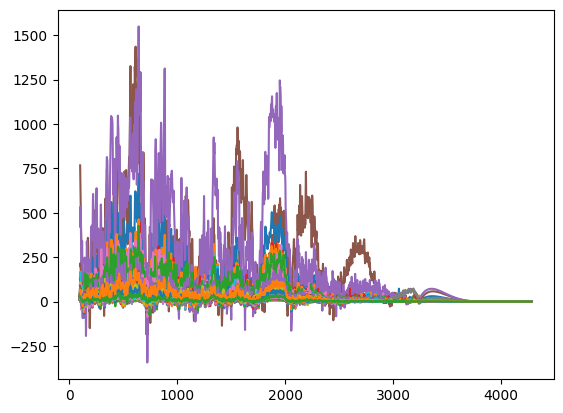

In [27]:
#just plotting everything to test
x_axis=np.linspace(100, 4278, 2090)
for i in range(0,len(df)):
    plt.plot(x_axis, df.iloc[i,0:2090])

In [28]:
#build the y dataset and drop target variable from df
#there is a better way to do it but this works...
y=df['target_variable']
df=df.drop(columns=['target_variable'])
X=df

In [29]:
#normalization of data
mean=X.mean()
std=X.std()
X_norm=(X-mean)/std


# Section 1.2
Benchmarking with a library I am familiar with (scikit-learn), so I have values to compare with the pytorch model

In [30]:
#not normalized run
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42)
model = MLPClassifier(hidden_layer_sizes=(2),
                      max_iter=1000,
                      random_state=42)

model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_train=model.predict(X_train)

accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_train=accuracy_score(y_train,y_pred_train)
print('train accuracy: ' +str(accuracy_train)+'\n'+'test accuracy: '+str(accuracy_test))

train accuracy: 0.6772151898734177
test accuracy: 0.6477987421383647


In [31]:
#normalized run
X_train, X_test, y_train, y_test = train_test_split(X_norm,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42)

model = MLPClassifier(hidden_layer_sizes=(2),
                      max_iter=1000,
                      random_state=42)

model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_train=model.predict(X_train)

accuracy_test_norm = accuracy_score(y_test, y_pred_test)
accuracy_train_norm=accuracy_score(y_train,y_pred_train)

print('train accuracy normalized: ' +str(accuracy_train_norm)+
      '\n'+'test accuracy normalized: '+str(accuracy_test_norm))

#normalization hugely improves performance, this is expected, but I wasnt expecting such a huge difference...

train accuracy normalized: 0.9978902953586498
test accuracy normalized: 0.9559748427672956


# Section 2
### Build of model and training/evaluating functions using pytorch and tensors

Disclaimer: this is the first time i've actually implemented something on pytorch

a problem i got that I don't know the best fix, is that the datatype of the values itself inside the tensors were not consistent

I just applied the method .float() and it worked...

In [32]:
torch.manual_seed(9000) #seed for consistency,

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [33]:
# dataframe to tensor and split using pytorch
x_tensor=torch.tensor(df.values)
y_tensor=torch.tensor(y.values)
x_norm_tensor=torch.tensor(X_norm.values)

#get random indices and number of entries in train set
indices=torch.randperm(len(x_tensor))
train_size=int(0.75*len(x_tensor))

#slice first 75% for train and latter 25% for testing
train_indices=indices[:train_size]
test_indices=indices[train_size:]

X_train_tensor=x_tensor[train_indices]
X_test_tensor=x_tensor[test_indices]
y_train_tensor=y_tensor[train_indices]
y_test_tensor=y_tensor[test_indices]

X_train_norm_tensor=x_norm_tensor[train_indices]
X_test_norm_tensor=x_norm_tensor[test_indices]

#building sets and loaders
train_set=TensorDataset(X_train_norm_tensor,y_train_tensor)
test_set=TensorDataset(X_test_norm_tensor,y_test_tensor)

train_loader=DataLoader(dataset=train_set,shuffle=True,batch_size=32)
test_loader=DataLoader(dataset=test_set,shuffle=False,batch_size=32)


In [34]:
#3 layer nn, hidden layer with 2 nodes
class classifier(nn.Module):
    def __init__(self, input_size):
        super(classifier,self).__init__()
        
        self.layer1=nn.Linear(input_size,2) #first connection
        self.layer2=nn.Linear(2,1) #second connection
        self.sigmoid=nn.Sigmoid()
        
    def forward(self, x):
        
        x=self.layer1(x)
        x=torch.relu(x)
        x=self.layer2(x)
        x=self.sigmoid(x)
        return x
    

In [35]:
#train
def train_model(model, criterion, optimizer, dataloader, epochs):
    model.train()  # training mode
    for epoch in range(epochs):
        total_loss = 0
        for input, output_true in dataloader:
            input = input.float() #had to apply .float() otherwise i'd get an error
            
            #had to use 'view' to have consistent shapes...
            output_true = output_true.float().view(-1, 1)

            optimizer.zero_grad()
            output_pred = model(input)
            loss = criterion(output_pred, output_true)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss}')
    return model
        

In [36]:
#I am not sure if this is the standard practice, but was the way i found
def calculate_accuracy(model, dataloader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad(): #stop gradients
        for input, output_true in dataloader:
            output_pred = model(input.float())
            binary_pred = (output_pred > 0.5).float() #convert bool to num
            correct += (binary_pred == output_true.float().view(-1, 1)).sum().item()
            total += output_true.size(0)
    model.train() # to train mode
    return correct / total


In [37]:
#reset and train this function for some reason never returns the trained model. I spent way too much time on this...
def reset_and_train(training_loader,epochs_in):
    #make sure the starting is the the same for every dataset training with this model
    torch.manual_seed(9000)
    
    #model ini
    model = classifier(x_tensor.shape[1])
    criterion = nn.BCELoss()    
    optimizer = optim.Adam(model.parameters(), lr=0.0003)
    epochs=epochs_in

    #train
    model=train_model(model,criterion,optimizer,training_loader,epochs)
    return model
    

In [45]:
model=reset_and_train(train_loader,2)

Epoch 1/2, Average Loss: 0.6301869630813599
Epoch 2/2, Average Loss: 0.6200520873069764


In [46]:
print('train accuracy'+
      str(calculate_accuracy(model,train_loader))+
      '\n'+
      'test accuracy:'+
      str(calculate_accuracy(model,test_loader)))

train accuracy0.6624472573839663
test accuracy:0.6918238993710691


With 15 epochs I get accuracies compatible with the values obtained by the other library

This is a good sign, values aren't the same becaus: shuffling of the sets are not identical and the number of epochs ran may be different...

### conclusion: the model functions most likely work

# Section 3
### Boruta

biggest challenge here is:

Boruta is designed to be used on random forests, where direct measures of variable importance are used... the least important features get dropped and the more important are retained..

When it comes to applyig boruta on other models, i.e NN, the same metrics aren't available, one has to be very careful when selecting a metric to evaluate variable importance

I'm thing that the F1 score is a good first guess to start, it is not a variable importance metric, it is a model performance metric but that may be useful to acess variable importance...
I'll test other metrics to validate this decision

In [40]:
#first, function to compute f1 score

def calculate_f1_score(model, dataloader):
    true_positives=0
    false_positives=0
    false_negatives=0
    
    #model in evaluation mode, resources point that it is better to leave it here
    #but is it necessary/good practice?
    model.eval()
    
    with torch.no_grad(): #stop gradients
        for input, output_true in dataloader:

            output_predict=model(input.float())
            binary_pred=(output_predict>0.5).float() #bool to num
            
            output_true=output_true.float().view(-1,1) #view, shape consistensy...
            
            true_positives+=((binary_pred==1) & (output_true==1)).sum().item()
            false_positives+=((binary_pred==1) & (output_true==0)).sum().item()
            false_negatives+=((binary_pred==0) & (output_true==1)).sum().item()
            
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    model.train()
    
    return f1_score
            

In [41]:
calculate_f1_score(model,test_loader)

0

In [42]:
def permutation_importance_f1_score(x,y,model,f1_score_function):
    
    #baseline f1score..., this is the only way i managed to reinitialize the model, I tried creating a function but this never worked...
    torch.manual_seed(9000)
    model=classifier(x_tensor.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0003)
    epochs=140
    train_model(model,criterion,optimizer,train_loader,epochs)
    baselinef1=calculate_f1_score(model,test_loader)
    

    #feature_importance
    for in in range()
    shuffle that featurem, leave the rest of the dataset as it is
    evaluate f1_score where that feature was shuffled
    
    importance=baseline - permutedf1
    append feature importance


SyntaxError: invalid syntax (628687288.py, line 14)